In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import netCDF4 as nc
import re

In [5]:
nncamrh_path = "/Users/jianda/Projects/experience_replay_data/nncamrh/nc_files/"
er_mixfull_perturbls_std_path = "/Users/jianda/Projects/experience_replay_data/er_mix1.0_perturbLS_std/replay_buffer_spinup5_seed1117_full_noprevQTLS_PerturbLS/nc_files/conv_mem_share3.cam.h1.1998-01-01-00000.nc"
er_mixfull_std_path = "/Users/jianda/Projects/experience_replay_data/er_mix1.0_std/nc_files/"
epmix_path = "/Users/jianda/Projects/experience_replay_data/mix0.5/conv_mem_share3.cam.h1.1998-01-01-00000.nc"

In [1]:
def load_precip_from_h1_nc(nc_dir_path, include_pattern=None, exclude_pattern=None):
    """
    Load precipitation data from h1.nc files in the given directory.
    Args:
        nc_dir_path (str): The directory path containing the h1.nc files.
        include_pattern (str): A regex pattern to include only specific files.
        exclude_pattern (str): A regex pattern to exclude specific files. include pattern is proritized over exclude pattern.
    Returns:
        pd.DataFrame: A concatenated DataFrame of precipitation data with time index.
    """
    dfs = []
    files = os.listdir(nc_dir_path)
    if exclude_pattern is not None:
        files = [file for file in files if not re.search(exclude_pattern, file)]
        excluded_files = [file for file in files if re.search(exclude_pattern, file)]
    if include_pattern is not None:
        included_files = [file for file in excluded_files if re.search(include_pattern, file)]
        files.extend(included_files)
    for file in files:
        if "h1" in file and file.endswith(".nc"):
            print(file)
            nc_data = nc.Dataset(nc_dir_path + file)["cp"]
            nc_data = nc_data[:] * 24 * 60 * 60 * 1000
            print(nc_data.mean())
            time = nc.Dataset(nc_dir_path + file)["time"]
            # Convert time to datetime
            time_values = nc.num2date(time[:], time.units)
            # Reshape precipitation arrays to 2D (time, lat*lon)
            nc_data_flat = nc_data.reshape(nc_data.shape[0], -1)
            # Convert cftime DatetimeGregorian to pandas datetime
            time_values_pd = pd.to_datetime([str(t) for t in time_values])
            # Create DataFrames with time index
            nc_df = pd.DataFrame(nc_data_flat, index=time_values_pd)
            dfs.append(nc_df)
    concat_df = pd.concat(dfs)
    concat_df = concat_df.sort_index()
    return concat_df


In [95]:
nncam_rh_precip = nc.Dataset(nncamrh_path)["cp"]
print(nncam_rh_precip)
ep_perturbls_precip = nc.Dataset(ep_perturbls_path)["cp"]
print(ep_perturbls_precip)
ep_precip = nc.Dataset(ep_path)["cp"]
print(ep_precip)
epmix_precip = nc.Dataset(epmix_path)["cp"]
print(epmix_precip)

<class 'netCDF4._netCDF4.Variable'>
float32 cp(time, lat, lon)
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (8760, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 cp(time, lat, lon)
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (8760, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 cp(time, lat, lon)
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (8760, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 cp(time, lat, lon)
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (8760, 96, 144)
filling on, default _FillValue of 9.9

In [96]:
nncam_rh_precip = nncam_rh_precip[:] * 24 * 60 * 60 * 1000
ep_perturbls_precip = ep_perturbls_precip[:] * 24 * 60 * 60 * 1000
ep_precip = ep_precip[:] * 24 * 60 * 60 * 1000
epmix_precip = epmix_precip[:] * 24 * 60 * 60 * 1000
print(nncam_rh_precip.mean())
print(ep_perturbls_precip.mean())
print(ep_precip.mean())
print(epmix_precip.mean())


2.408908
2.165688
2.1382892
2.1132562


In [28]:
time = nc.Dataset(ep_perturbls_path)["time"]
print(time)
# Convert time to datetime
time_values = nc.num2date(time[:], time.units)
print(time_values.shape)

# Reshape precipitation arrays to 2D (time, lat*lon)
nncam_rh_precip_flat = nncam_rh_precip.reshape(nncam_rh_precip.shape[0], -1)
ep_perturbls_precip_flat = ep_perturbls_precip.reshape(ep_perturbls_precip.shape[0], -1)
ep_precip_flat = ep_precip.reshape(ep_precip.shape[0], -1)
epmix_precip_flat = epmix_precip.reshape(epmix_precip.shape[0], -1)
# Convert cftime DatetimeGregorian to pandas datetime
time_values_pd = pd.to_datetime([str(t) for t in time_values])

# Create DataFrames with time index
nncam_df = pd.DataFrame(nncam_rh_precip_flat, index=time_values_pd)
ep_perturbls_df = pd.DataFrame(ep_perturbls_precip_flat, index=time_values_pd)
ep_df = pd.DataFrame(ep_precip_flat, index=time_values_pd)
epmix_df = pd.DataFrame(epmix_precip_flat, index=time_values_pd)


<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    long_name: time
    units: days since 1998-01-01 00:00:00
    calendar: noleap
    bounds: time_bnds
unlimited dimensions: time
current shape = (8760,)
filling on, default _FillValue of 9.969209968386869e+36 used
(8760,)


In [112]:
noep_minmax_dir = "/Users/jianda/Projects/experience_replay_data/noep_minmax_data/nc_files/"
dfs = []
for file in os.listdir(noep_minmax_dir):
    if "h1" in file and file.endswith(".nc"):
        print(file)
        noep_minmax_data = nc.Dataset(noep_minmax_dir + file)["cp"]
        noep_minmax_data = noep_minmax_data[:] * 24 * 60 * 60 * 1000
        print(noep_minmax_data.mean())
        time = nc.Dataset(noep_minmax_dir + file)["time"]
        # Convert time to datetime
        time_values = nc.num2date(time[:], time.units)
        # Reshape precipitation arrays to 2D (time, lat*lon)
        noep_minmax_data_flat = noep_minmax_data.reshape(noep_minmax_data.shape[0], -1)

        # Convert cftime DatetimeGregorian to pandas datetime
        time_values_pd = pd.to_datetime([str(t) for t in time_values])
        # Create DataFrames with time index
        noep_minmax_df = pd.DataFrame(noep_minmax_data_flat, index=time_values_pd)
        dfs.append(noep_minmax_df)
noep_minmax_df = pd.concat(dfs)
noep_minmax_df = noep_minmax_df.sort_index()
noep_minmax_df.to_csv("/Users/jianda/Projects/experience_replay_data/noep_minmax_data/noep_minmax_precip.csv")

conv_mem_share3.cam.h1.1999-04-26-00000.nc
2.1080682
conv_mem_share3.cam.h1.1998-11-27-00000.nc
2.032234
conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.081493
conv_mem_share3.cam.h1.1999-01-26-00000.nc
1.9983617
conv_mem_share3.cam.h1.1998-10-28-00000.nc
2.0130916
conv_mem_share3.cam.h1.1998-12-27-00000.nc
1.99799
conv_mem_share3.cam.h1.1998-09-28-00000.nc
2.0526865
conv_mem_share3.cam.h1.1998-07-30-00000.nc
2.1623087
conv_mem_share3.cam.h1.1998-05-01-00000.nc
2.1521006
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.0787337
conv_mem_share3.cam.h1.1998-05-31-00000.nc
2.1800334
conv_mem_share3.cam.h1.1999-05-26-00000.nc
2.147828
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.072044
conv_mem_share3.cam.h1.1998-08-29-00000.nc
2.1153886
conv_mem_share3.cam.h1.1998-06-30-00000.nc
2.2258806
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.1498857
conv_mem_share3.cam.h1.1999-03-27-00000.nc
2.0473115
conv_mem_share3.cam.h1.1999-02-25-00000.nc
2.0300324


In [97]:
noep_minmax_df = pd.read_csv("/Users/jianda/Projects/experience_replay_data/noep_minmax_data/noep_minmax_precip.csv")

In [105]:
nncam_base_dir = "/Users/jianda/Projects/experience_replay_data/nncam_data/nc_files/"
dfs = []
for file in os.listdir(nncam_base_dir):
    if "h1" in file and file.endswith(".nc"):
        print(file)
        nncam_base_data = nc.Dataset(nncam_base_dir + file)["cp"]
        nncam_base_data = nncam_base_data[:] * 24 * 60 * 60 * 1000
        print(nncam_base_data.mean())
        time = nc.Dataset(nncam_base_dir + file)["time"]
        # Convert time to datetime
        time_values = nc.num2date(time[:], time.units)
        # Reshape precipitation arrays to 2D (time, lat*lon)
        nncam_base_data_flat = nncam_base_data.reshape(nncam_base_data.shape[0], -1)

        # Convert cftime DatetimeGregorian to pandas datetime
        time_values_pd = pd.to_datetime([str(t) for t in time_values])
        # Create DataFrames with time index
        nncam_base_df = pd.DataFrame(nncam_base_data_flat, index=time_values_pd)
        dfs.append(nncam_base_df)
nncam_base_df = pd.concat(dfs)
nncam_base_df = nncam_base_df.sort_index()
nncam_base_df.to_csv("/Users/jianda/Projects/experience_replay_data/nncam_data/nncam_precip.csv")

conv_mem_share3.cam.h1.1999-04-26-00000.nc
2.2401977
conv_mem_share3.cam.h1.1998-11-27-00000.nc
2.2288957
conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.15566
conv_mem_share3.cam.h1.1999-01-26-00000.nc
2.2408836
conv_mem_share3.cam.h1.1998-10-28-00000.nc
2.2075698
conv_mem_share3.cam.h1.1998-12-27-00000.nc
2.192814
conv_mem_share3.cam.h1.1998-09-28-00000.nc
2.2194655
conv_mem_share3.cam.h1.1998-07-30-00000.nc
2.339897
conv_mem_share3.cam.h1.1998-05-01-00000.nc
2.2658827
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.2481048
conv_mem_share3.cam.h1.1998-05-31-00000.nc
2.3109875
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.2330842
conv_mem_share3.cam.h1.1998-08-29-00000.nc
2.2590735
conv_mem_share3.cam.h1.1998-06-30-00000.nc
2.329338
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.2711115
conv_mem_share3.cam.h1.1999-03-27-00000.nc
2.1751292
conv_mem_share3.cam.h1.1999-02-25-00000.nc
2.1742458


In [98]:
nncam_base_df = pd.read_csv("/Users/jianda/Projects/experience_replay_data/nncam_data/nncam_precip.csv")

In [60]:
perturbls_minmax_base_dir = "/Users/jianda/Projects/experience_replay_data/perturbLS_minmax_data/nc_files/"
dfs = []
for file in os.listdir(perturbls_minmax_base_dir):
    if "h1" in file and file.endswith(".nc"):
        print(file)
        perturbls_minmax_data = nc.Dataset(perturbls_minmax_base_dir + file)["cp"]
        perturbls_minmax_data = perturbls_minmax_data[:] * 24 * 60 * 60 * 1000
        print(perturbls_minmax_data.mean())
        time = nc.Dataset(perturbls_minmax_base_dir + file)["time"]
        # Convert time to datetime
        time_values = nc.num2date(time[:], time.units)
        # Reshape precipitation arrays to 2D (time, lat*lon)
        perturbls_minmax_data_flat = perturbls_minmax_data.reshape(perturbls_minmax_data.shape[0], -1)

        # Convert cftime DatetimeGregorian to pandas datetime
        time_values_pd = pd.to_datetime([str(t) for t in time_values])
        # Create DataFrames with time index
        perturbls_minmax_df = pd.DataFrame(perturbls_minmax_data_flat, index=time_values_pd)
        dfs.append(perturbls_minmax_df)
perturbls_minmax_df = pd.concat(dfs)
perturbls_minmax_df = perturbls_minmax_df.sort_index()
perturbls_minmax_df.to_csv("/Users/jianda/Projects/experience_replay_data/perturbLS_minmax_data/perturbLS_minmax_precip.csv")

conv_mem_share3.cam.h1.1998-11-27-00000.nc
2.1371474
conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.155883
conv_mem_share3.cam.h1.1998-10-28-00000.nc
2.0987363
conv_mem_share3.cam.h1.1998-12-27-00000.nc
2.1222367
conv_mem_share3.cam.h1.1998-09-28-00000.nc
2.1116936
conv_mem_share3.cam.h1.1998-07-30-00000.nc
2.2338982
conv_mem_share3.cam.h1.1998-05-01-00000.nc
2.1861708
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.1006513
conv_mem_share3.cam.h1.1998-05-31-00000.nc
2.2103925
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.115459
conv_mem_share3.cam.h1.1998-08-29-00000.nc
2.2077255
conv_mem_share3.cam.h1.1998-06-30-00000.nc
2.227601
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.1321418


In [99]:
perturbls_minmax_df = pd.read_csv("/Users/jianda/Projects/experience_replay_data/perturbLS_minmax_data/perturbLS_minmax_precip.csv")

In [86]:
# perturbls_minmax_base_dir = "/Users/jianda/Projects/experience_replay_data/perturbLS_minmax_data/"
# dfs = []
# for file in os.listdir(perturbls_minmax_base_dir):
#     if "h1" in file and file.endswith(".nc"):
#         print(file)
#         perturbls_minmax_data = nc.Dataset(perturbls_minmax_base_dir + file)["cp"]
#         perturbls_minmax_data = perturbls_minmax_data[:] * 24 * 60 * 60 * 1000
#         print(perturbls_minmax_data.mean())
#         time = nc.Dataset(perturbls_minmax_base_dir + file)["time"]
#         # Convert time to datetime
#         time_values = nc.num2date(time[:], time.units)
#         # Reshape precipitation arrays to 2D (time, lat*lon)
#         perturbls_minmax_data_flat = perturbls_minmax_data.reshape(perturbls_minmax_data.shape[0], -1)

#         # Convert cftime DatetimeGregorian to pandas datetime
#         time_values_pd = pd.to_datetime([str(t) for t in time_values])
#         # Create DataFrames with time index
#         perturbls_minmax_df = pd.DataFrame(perturbls_minmax_data_flat, index=time_values_pd)
#         dfs.append(perturbls_minmax_df)
# perturbls_minmax_1999_df = pd.concat(dfs)
# perturbls_minmax_1999_df = perturbls_minmax_1999_df.sort_index()
# perturbls_minmax_1999_df.to_csv("/Users/jianda/Projects/experience_replay_data/perturbLS_minmax_data/perturbLS_minmax_precip_1999.csv")

conv_mem_share3.cam.h1.1999-04-26-00000.nc
2.1106758
conv_mem_share3.cam.h1.1999-01-26-00000.nc
2.1057837
conv_mem_share3.cam.h1.1998-12-27-00000.nc
2.1222367
conv_mem_share3.cam.h1.1999-05-26-00000.nc
2.235125
conv_mem_share3.cam.h1.1999-03-27-00000.nc
2.0701675
conv_mem_share3.cam.h1.1999-02-25-00000.nc
2.1079285


In [109]:
mix_minmax_base_dir = "/Users/jianda/Projects/experience_replay_data/ep_mix0.5_minmax/nc_files/"
dfs = []
for file in os.listdir(mix_minmax_base_dir):
    if "h1" in file and file.endswith(".nc") and "04" not in file:
        print(file)
        mix_minmax_data = nc.Dataset(mix_minmax_base_dir + file)["cp"]
        mix_minmax_data = mix_minmax_data[:] * 24 * 60 * 60 * 1000
        print(mix_minmax_data.mean())
        time = nc.Dataset(mix_minmax_base_dir + file)["time"]
        # Convert time to datetime
        time_values = nc.num2date(time[:], time.units)
        # Reshape precipitation arrays to 2D (time, lat*lon)
        mix_minmax_data_flat = mix_minmax_data.reshape(mix_minmax_data.shape[0], -1)

        # Convert cftime DatetimeGregorian to pandas datetime
        time_values_pd = pd.to_datetime([str(t) for t in time_values])
        # Create DataFrames with time index
        mix_minmax_df = pd.DataFrame(mix_minmax_data_flat, index=time_values_pd)
        dfs.append(mix_minmax_df)
mix_minmax_df = pd.concat(dfs)
mix_minmax_df = mix_minmax_df.sort_index()
mix_minmax_df.to_csv("/Users/jianda/Projects/experience_replay_data/ep_mix0.5_minmax/ep_mix0.5_minmax_precip.csv")

conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.1372678
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.108679
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.1564398


In [100]:
noep_precip_online = pd.read_csv("/Users/jianda/Projects/experience_replay_data/noep_precip/noep_precip.csv")
spcam_precip = pd.read_csv("/Users/jianda/Projects/experience_replay_data/spcam_data/spcam_precip.csv")

In [101]:
PLOT_CONFIG = {
    'xlabel': 'mm/day',
    'ylabel': 'Probability Density (%)',
    'title': 'Precipitation 1998 Jan-Mar Bin size: 1mm/day',
    'ylim': (1e-7, 100),
    'xlim': (0, 220),
    'xticks': range(0, 221, 20),
    'yticks': {
        'values': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'labels': ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1', '10', '100']
    },
     'figsize': (10, 8),
    'legend_loc': 'upper right',
    'legend_fontsize': 12,
    'label_fontsize': 12,
    'title_fontsize': 14,
    'tick_fontsize': 10,
    'colors': ['black', 'orange', 'orange', 'red', 'red', 'purple', 'purple', 'pink', 'pink']
}

In [102]:
nncam_df.index = pd.to_datetime(nncam_df.index)
nncam_base_df.index = pd.to_datetime(nncam_base_df.index)
ep_df.index = pd.to_datetime(ep_df.index)
noep_minmax_df.index = pd.to_datetime(noep_minmax_df.index)
noep_precip_online['Unnamed: 0'] = pd.to_datetime(noep_precip_online['Unnamed: 0'])
noep_precip_online.set_index('Unnamed: 0', inplace=True)
spcam_precip['Unnamed: 0'] = pd.to_datetime(spcam_precip['Unnamed: 0'])
spcam_precip.set_index('Unnamed: 0', inplace=True)

epmix_df.index = pd.to_datetime(epmix_df.index)
ep_perturbls_df.index = pd.to_datetime(ep_perturbls_df.index)
perturbls_minmax_df.index = pd.to_datetime(perturbls_minmax_df.index)


In [110]:
mix_minmax_df.index = pd.to_datetime(mix_minmax_df.index)

/opt/homebrew/Caskroom/miniconda/base/envs/nncam/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Setting plot limits and ticks


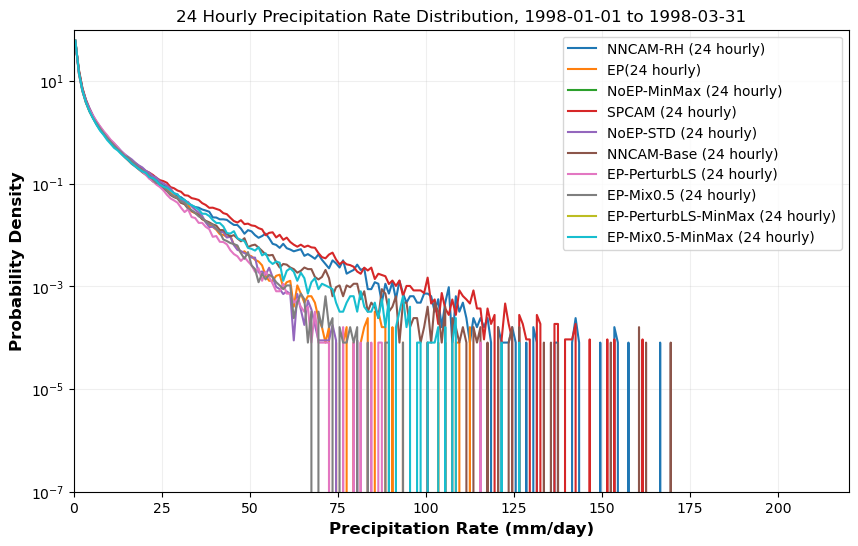

In [111]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
# perturbls_minmax_hourly = perturbls_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
perturbls_minmax_hourly = perturbls_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
mix_minmax_hourly = mix_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
perturbls_minmax_flat_hourly = perturbls_minmax_hourly.values.flatten()
mix_minmax_flat_hourly = mix_minmax_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_perturbls_minmax, bins_perturbls_minmax = np.histogram(perturbls_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_mix_minmax, bins_mix_minmax = np.histogram(mix_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
bin_centers_perturbls_minmax = (bins_perturbls_minmax[:-1] + bins_perturbls_minmax[1:]) / 2
bin_centers_mix_minmax = (bins_mix_minmax[:-1] + bins_mix_minmax[1:]) / 2

plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (24 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP(24 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (24 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (24 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (24 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (24 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (24 hourly)')
plt.semilogy(bin_centers_perturbls_minmax, hist_perturbls_minmax*100, label='EP-PerturbLS-MinMax (24 hourly)')
plt.semilogy(bin_centers_mix_minmax, hist_mix_minmax*100, label='EP-Mix0.5-MinMax (24 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('24 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/nncam/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Setting plot limits and ticks


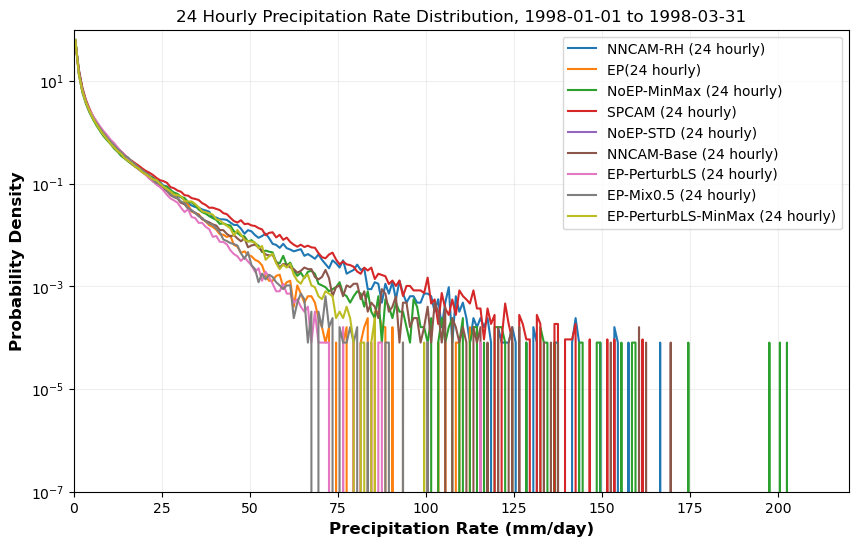

In [70]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
perturbls_minmax_hourly = perturbls_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
perturbls_minmax_flat_hourly = perturbls_minmax_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_perturbls_minmax, bins_perturbls_minmax = np.histogram(perturbls_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
bin_centers_perturbls_minmax = (bins_perturbls_minmax[:-1] + bins_perturbls_minmax[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (24 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP(24 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (24 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (24 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (24 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (24 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (24 hourly)')
plt.semilogy(bin_centers_perturbls_minmax, hist_perturbls_minmax*100, label='EP-PerturbLS-MinMax (24 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('24 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


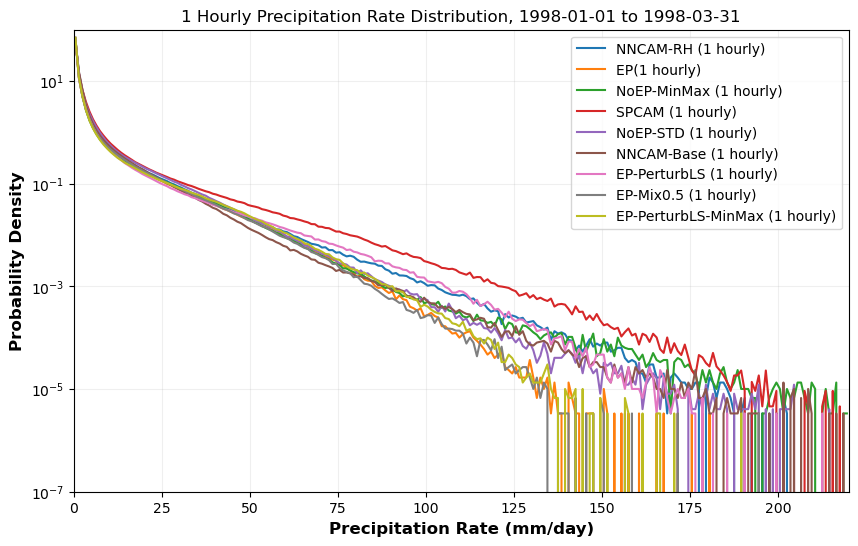

In [90]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
perturbls_minmax_hourly = perturbls_minmax_1999_df.loc['1999-01-01':'1999-03-31'].resample('1h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
perturbls_minmax_flat_hourly = perturbls_minmax_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_perturbls_minmax, bins_perturbls_minmax = np.histogram(perturbls_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
bin_centers_perturbls_minmax = (bins_perturbls_minmax[:-1] + bins_perturbls_minmax[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (1 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP(1 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (1 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (1 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (1 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (1 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (1 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (1 hourly)')
plt.semilogy(bin_centers_perturbls_minmax, hist_perturbls_minmax*100, label='EP-PerturbLS-MinMax (1 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('1 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


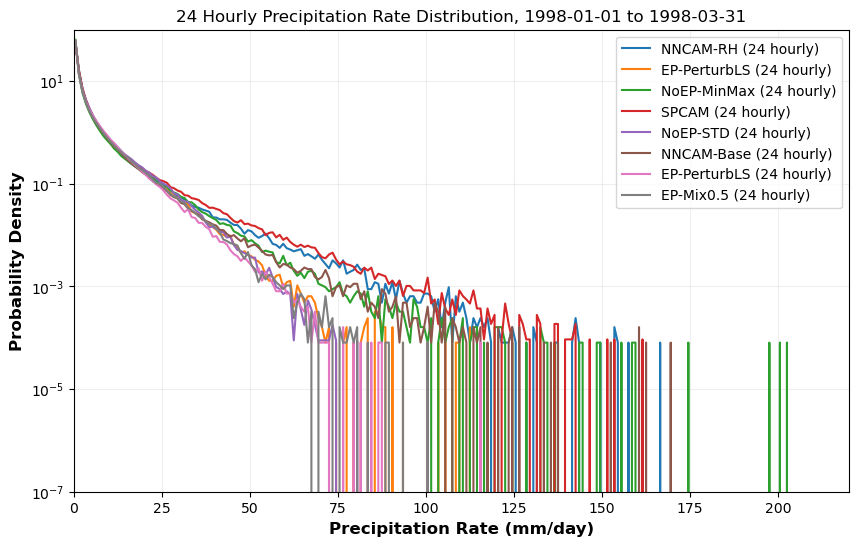

In [82]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (24 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (24 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (24 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (24 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (24 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (24 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (24 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('24 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


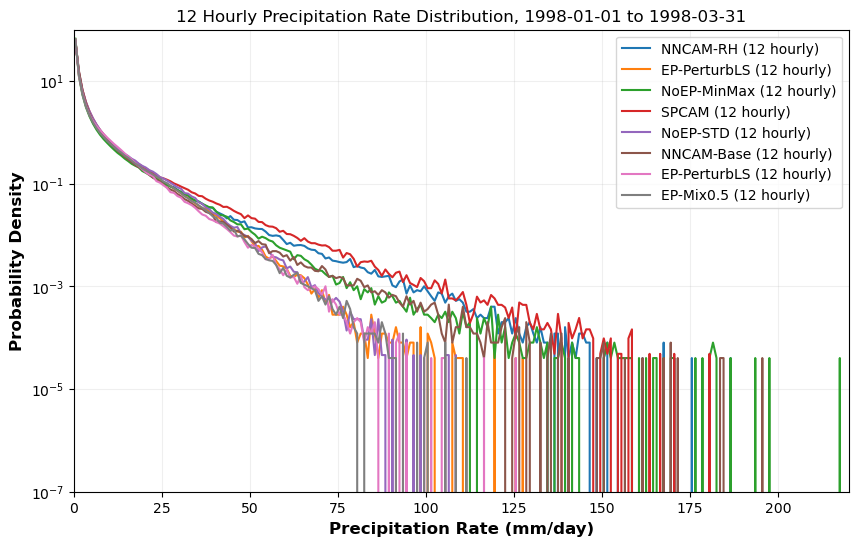

In [117]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('12h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('12h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (12 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (12 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (12 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (12 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (12 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (12 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (12 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (12 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('12 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


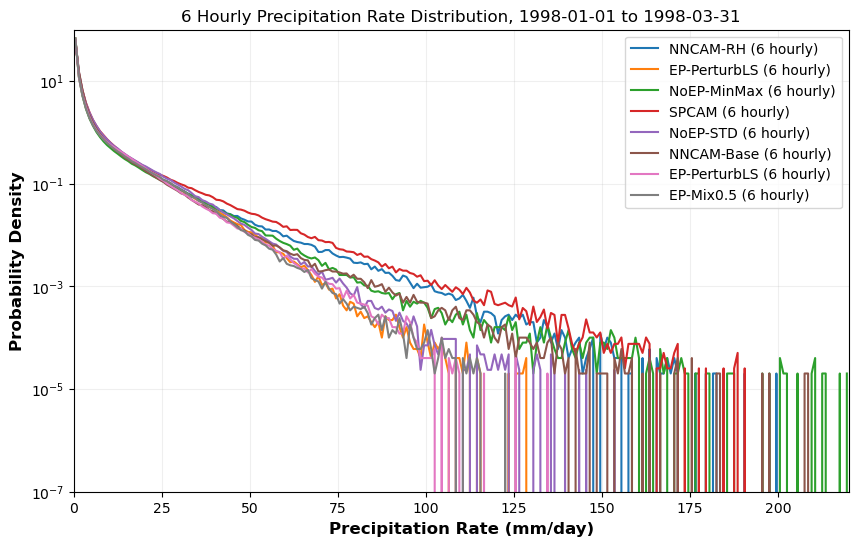

In [118]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('6h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('6h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (6 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (6 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (6 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (6 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (6 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (6 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (6 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (6 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('6 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


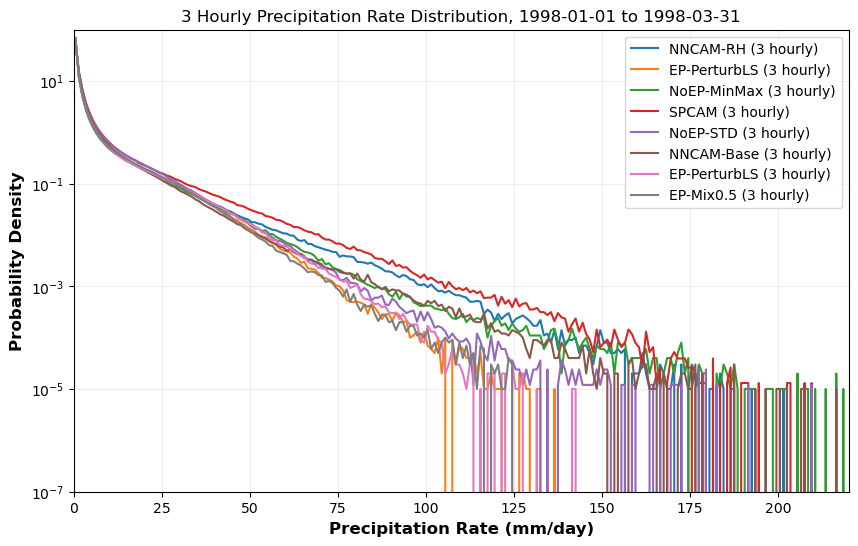

In [119]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (3 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (3 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (3 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (3 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (3 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (3 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (3 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (3 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('3 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [91]:
# Define threshold for precipitation (mm/day)
thresholds = [0.1, 10, 40,  100.0, 200.0]  # Can be adjusted as needed

nncam_daily = nncam_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
nncam_base_daily = nncam_base_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
ep_daily = ep_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
ep_perturb_daily = ep_perturbls_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
epmix_daily = epmix_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
noep_minmax_daily = noep_minmax_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
noep_std_daily = noep_precip_online.loc['1998-01-02':'1998-03-31'].resample('1h').mean().values.reshape(-1, 24, 13824)
spcam_daily = spcam_precip.loc['1998-01-02':'1998-03-31'].resample('1h').mean().values.reshape(-1, 24, 13824)
perturb_minmax_daily = perturbls_minmax_1999_df.loc['1999-01-02':'1999-03-31'].values.reshape(-1, 24, 13824)
# Initialize arrays to store consecutive precipitation counts
nncam_consecutive = np.zeros_like(nncam_daily[0,:,:])  # Shape (13824,)
nncam_base_consecutive = np.zeros_like(nncam_base_daily[0,:,:])  # Shape (13824,)
ep_perturb_consecutive = np.zeros_like(ep_perturb_daily[0,:,:])  # Shape (13824,)
ep_consecutive = np.zeros_like(ep_daily[0,:,:])  # Shape (13824,)
epmix_consecutive = np.zeros_like(epmix_daily[0,:,:])  # Shape (13824,)
noep_minmax_consecutive = np.zeros_like(noep_minmax_daily[0,:,:])  # Shape (13824,)
noep_std_consecutive = np.zeros_like(noep_std_daily[0,:,:])  # Shape (13824,)
spcam_consecutive = np.zeros_like(spcam_daily[0,:,:])  # Shape (13824,)
perturb_minmax_consecutive = np.zeros_like(perturb_minmax_daily[0,:,:])  # Shape (13824,)



# Create rolling windows of 3 hours for each day and grid point
nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
nncam_base_windows = np.lib.stride_tricks.sliding_window_view(nncam_base_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
ep_perturb_windows = np.lib.stride_tricks.sliding_window_view(ep_perturb_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
epmix_windows = np.lib.stride_tricks.sliding_window_view(epmix_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
noep_minmax_windows = np.lib.stride_tricks.sliding_window_view(noep_minmax_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
noep_std_windows = np.lib.stride_tricks.sliding_window_view(noep_std_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
spcam_windows = np.lib.stride_tricks.sliding_window_view(spcam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
perturb_minmax_windows = np.lib.stride_tricks.sliding_window_view(perturb_minmax_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)

# nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)
print(nncam_windows.shape)
print(ep_windows.shape)
print(nncam_base_windows.shape)
print(ep_perturb_windows.shape)
print(epmix_windows.shape)
print(noep_minmax_windows.shape)
print(noep_std_windows.shape)
print(spcam_windows.shape)
print(perturb_minmax_windows.shape)
# ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)


nncam_consecutives = []
ep_consecutives = []
nncam_base_consecutives = []
ep_perturb_consecutives = []
epmix_consecutives = []
noep_minmax_consecutives = []
noep_std_consecutives = []
spcam_consecutives = []
perturb_minmax_consecutives = []
# # Check where all values in each window exceed threshold
for threshold in thresholds:
    print(f"\nFor threshold {threshold} mm/day:")
    nncam_consecutive_periods = np.all(nncam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    ep_consecutive_periods = np.all(ep_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    nncam_base_consecutive_periods = np.all(nncam_base_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    ep_perturb_consecutive_periods = np.all(ep_perturb_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    epmix_consecutive_periods = np.all(epmix_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    noep_minmax_consecutive_periods = np.all(noep_minmax_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    noep_std_consecutive_periods = np.all(noep_std_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    spcam_consecutive_periods = np.all(spcam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    perturb_minmax_consecutive_periods = np.all(perturb_minmax_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    
    # Sum across days and hours to get total count for each grid point
    nncam_consecutive = np.sum(nncam_consecutive_periods)  # Shape (13824,)
    ep_consecutive = np.sum(ep_consecutive_periods)  # Shape (13824,)
    nncam_base_consecutive = np.sum(nncam_base_consecutive_periods)  # Shape (13824,)
    ep_perturb_consecutive = np.sum(ep_perturb_consecutive_periods)  # Shape (13824,)
    epmix_consecutive = np.sum(epmix_consecutive_periods)  # Shape (13824,)
    noep_minmax_consecutive = np.sum(noep_minmax_consecutive_periods)  # Shape (13824,)
    noep_std_consecutive = np.sum(noep_std_consecutive_periods)  # Shape (13824,)
    spcam_consecutive = np.sum(spcam_consecutive_periods)  # Shape (13824,)
    perturb_minmax_consecutive = np.sum(perturb_minmax_consecutive_periods)  # Shape (13824,)

    nncam_consecutives.append(nncam_consecutive)
    ep_consecutives.append(ep_consecutive)
    nncam_base_consecutives.append(nncam_base_consecutive)
    ep_perturb_consecutives.append(ep_perturb_consecutive)
    epmix_consecutives.append(epmix_consecutive)
    noep_minmax_consecutives.append(noep_minmax_consecutive)
    noep_std_consecutives.append(noep_std_consecutive)
    spcam_consecutives.append(spcam_consecutive)
    perturb_minmax_consecutives.append(perturb_minmax_consecutive)
    print(f"NNCAM-RH consecutive periods: {nncam_consecutive}")
    print(f"EP-PerturbLS consecutive periods: {ep_consecutive}")
    print(f"NNCAM-Base consecutive periods: {nncam_base_consecutive}")
    print(f"EP-PerturbLS consecutive periods: {ep_perturb_consecutive}")
    print(f"EP-PerturbLS-MinMax consecutive periods: {perturb_minmax_consecutive}")
    print(f"EP-Mix consecutive periods: {epmix_consecutive}")
    print(f"NoEP-MinMax consecutive periods: {noep_minmax_consecutive}")
    print(f"NoEP-Std consecutive periods: {noep_std_consecutive}")
    print(f"SPCAM consecutive periods: {spcam_consecutive}")


(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)
(89, 22, 13824, 3)

For threshold 0.1 mm/day:
NNCAM-RH consecutive periods: 16362463
EP-PerturbLS consecutive periods: 16581499
NNCAM-Base consecutive periods: 17035491
EP-PerturbLS consecutive periods: 16198026
EP-PerturbLS-MinMax consecutive periods: 17345218
EP-Mix consecutive periods: 16479649
NoEP-MinMax consecutive periods: 17396972
NoEP-Std consecutive periods: 16324447
SPCAM consecutive periods: 11937101

For threshold 10 mm/day:
NNCAM-RH consecutive periods: 1207184
EP-PerturbLS consecutive periods: 913055
NNCAM-Base consecutive periods: 1134945
EP-PerturbLS consecutive periods: 723093
EP-PerturbLS-MinMax consecutive periods: 961534
EP-Mix consecutive periods: 929963
NoEP-MinMax consecutive periods: 1065427
NoEP-Std consecutive periods: 949170
SPCAM consecutive periods: 884144

For threshold 40 mm/day:
NNCAM-RH consecutive peri

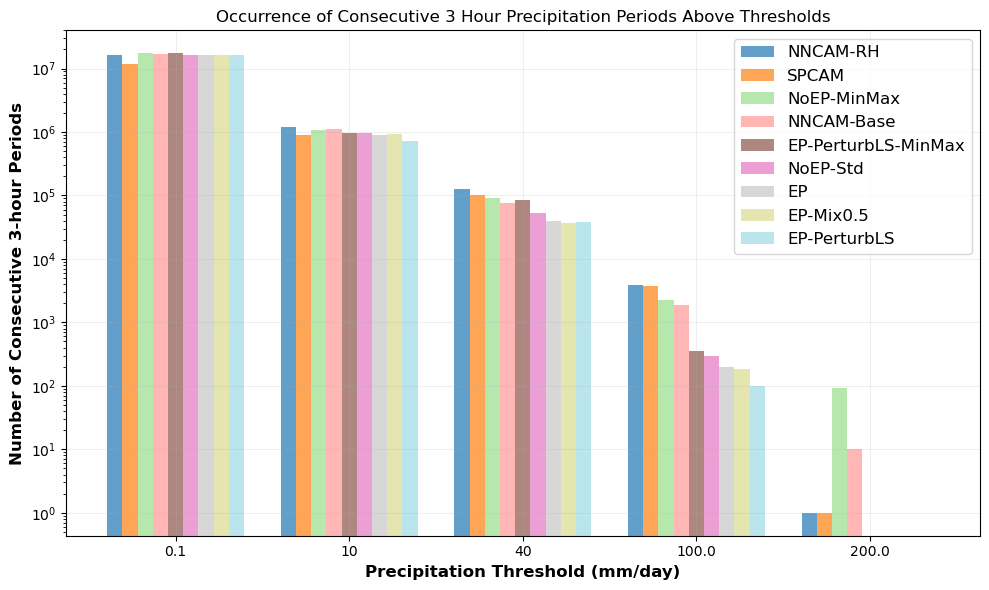

In [92]:
# Plot the occurrence of consecutive precipitation periods for each threshold
plt.figure(figsize=(10, 6))  # Explicitly set DPI to control output size

x = np.arange(len(thresholds))
width = 0.35

# Create dictionary of model data and colors
model_data = {
    'NNCAM-RH': nncam_consecutives,
    'EP': ep_consecutives,
    'NNCAM-Base': nncam_base_consecutives,
    'EP-PerturbLS': ep_perturb_consecutives, 
    'EP-PerturbLS-MinMax': perturb_minmax_consecutives,
    'EP-Mix0.5': epmix_consecutives,
    'NoEP-MinMax': noep_minmax_consecutives,
    'NoEP-Std': noep_std_consecutives,
    'SPCAM': spcam_consecutives
}

# Sort models by second last value
sorted_models = sorted(model_data.items(), 
                      key=lambda x: x[1][-2],
                      reverse=True)

colors = plt.cm.tab20(np.linspace(0, 1, len(model_data)))

# Plot bars for each model
for i, (model, values) in enumerate(sorted_models):
    plt.bar(x + i*width/4 - width, values,
            width=width/4,
            label=model,
            alpha=0.7,
            color=colors[i])

plt.xlabel('Precipitation Threshold (mm/day)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel('Number of Consecutive 3-hour Periods', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.title('Occurrence of Consecutive 3 Hour Precipitation Periods Above Thresholds')
plt.xticks(x, thresholds, fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(fontsize=PLOT_CONFIG['tick_fontsize'])
plt.legend(fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, alpha=0.2)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to prevent text cutoff
plt.show()


In [124]:
# Define threshold for precipitation (mm/day)
thresholds = [0.1, 10, 40,  100.0, 200.0]  # Can be adjusted as needed

nncam_daily = nncam_df.loc['1998-01-02':'1999-01-02'].values.reshape(-1, 24, 13824)
nncam_base_daily = nncam_base_df.loc['1998-01-02':'1999-01-02'].values.reshape(-1, 24, 13824)
ep_daily = ep_df.loc['1998-01-02':'1999-01-02'].values.reshape(-1, 24, 13824)
ep_perturb_daily = ep_perturbls_df.loc['1998-01-02':'1999-01-02'].values.reshape(-1, 24, 13824)
epmix_daily = epmix_df.loc['1998-01-02':'1999-01-02'].values.reshape(-1, 24, 13824)
# noep_minmax_daily = noep_minmax_df.loc['1998-01-02':'1998-03-31'].values.reshape(-1, 24, 13824)
# noep_std_daily = noep_precip_online.loc['1998-01-02':'1998-03-31'].resample('1h').mean().values.reshape(-1, 24, 13824)
spcam_daily = spcam_precip.loc['1998-01-02':'1999-01-02'].resample('1h').mean().values.reshape(-1, 24, 13824)
# Initialize arrays to store consecutive precipitation counts
nncam_consecutive = np.zeros_like(nncam_daily[0,:,:])  # Shape (13824,)
nncam_base_consecutive = np.zeros_like(nncam_base_daily[0,:,:])  # Shape (13824,)
ep_perturb_consecutive = np.zeros_like(ep_perturb_daily[0,:,:])  # Shape (13824,)
ep_consecutive = np.zeros_like(ep_daily[0,:,:])  # Shape (13824,)
epmix_consecutive = np.zeros_like(epmix_daily[0,:,:])  # Shape (13824,)
# noep_minmax_consecutive = np.zeros_like(noep_minmax_daily[0,:,:])  # Shape (13824,)
# noep_std_consecutive = np.zeros_like(noep_std_daily[0,:,:])  # Shape (13824,)
spcam_consecutive = np.zeros_like(spcam_daily[0,:,:])  # Shape (13824,)


# Create rolling windows of 3 hours for each day and grid point
nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
nncam_base_windows = np.lib.stride_tricks.sliding_window_view(nncam_base_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
ep_perturb_windows = np.lib.stride_tricks.sliding_window_view(ep_perturb_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
epmix_windows = np.lib.stride_tricks.sliding_window_view(epmix_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
noep_minmax_windows = np.lib.stride_tricks.sliding_window_view(noep_minmax_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
noep_std_windows = np.lib.stride_tricks.sliding_window_view(noep_std_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
spcam_windows = np.lib.stride_tricks.sliding_window_view(spcam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)

# nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)
print(nncam_windows.shape)
print(ep_windows.shape)
print(nncam_base_windows.shape)
print(ep_perturb_windows.shape)
print(epmix_windows.shape)
# print(noep_minmax_windows.shape)
# print(noep_std_windows.shape)
print(spcam_windows.shape)
# ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)


nncam_consecutives = []
ep_consecutives = []
nncam_base_consecutives = []
ep_perturb_consecutives = []
epmix_consecutives = []
noep_minmax_consecutives = []
noep_std_consecutives = []
spcam_consecutives = []

# # Check where all values in each window exceed threshold
for threshold in thresholds:
    print(f"\nFor threshold {threshold} mm/day:")
    nncam_consecutive_periods = np.all(nncam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    ep_consecutive_periods = np.all(ep_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    nncam_base_consecutive_periods = np.all(nncam_base_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    ep_perturb_consecutive_periods = np.all(ep_perturb_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    epmix_consecutive_periods = np.all(epmix_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    # noep_minmax_consecutive_periods = np.all(noep_minmax_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    # noep_std_consecutive_periods = np.all(noep_std_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    spcam_consecutive_periods = np.all(spcam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    
    # Sum across days and hours to get total count for each grid point
    nncam_consecutive = np.sum(nncam_consecutive_periods)  # Shape (13824,)
    ep_consecutive = np.sum(ep_consecutive_periods)  # Shape (13824,)
    nncam_base_consecutive = np.sum(nncam_base_consecutive_periods)  # Shape (13824,)
    ep_perturb_consecutive = np.sum(ep_perturb_consecutive_periods)  # Shape (13824,)
    epmix_consecutive = np.sum(epmix_consecutive_periods)  # Shape (13824,)
    # noep_minmax_consecutive = np.sum(noep_minmax_consecutive_periods)  # Shape (13824,)
    # noep_std_consecutive = np.sum(noep_std_consecutive_periods)  # Shape (13824,)
    spcam_consecutive = np.sum(spcam_consecutive_periods)  # Shape (13824,)

    nncam_consecutives.append(nncam_consecutive)
    ep_consecutives.append(ep_consecutive)
    nncam_base_consecutives.append(nncam_base_consecutive)
    ep_perturb_consecutives.append(ep_perturb_consecutive)
    epmix_consecutives.append(epmix_consecutive)
    # noep_minmax_consecutives.append(noep_minmax_consecutive)
    # noep_std_consecutives.append(noep_std_consecutive)
    spcam_consecutives.append(spcam_consecutive)
    
    print(f"NNCAM-RH consecutive periods: {nncam_consecutive}")
    print(f"EP-PerturbLS consecutive periods: {ep_consecutive}")
    print(f"NNCAM-Base consecutive periods: {nncam_base_consecutive}")
    print(f"EP-PerturbLS consecutive periods: {ep_perturb_consecutive}")
    print(f"EP-Mix consecutive periods: {epmix_consecutive}")
    # print(f"NoEP-MinMax consecutive periods: {noep_minmax_consecutive}")
    # print(f"NoEP-Std consecutive periods: {noep_std_consecutive}")
    print(f"SPCAM consecutive periods: {spcam_consecutive}")


(364, 22, 13824, 3)
(364, 22, 13824, 3)
(366, 22, 13824, 3)
(364, 22, 13824, 3)
(364, 22, 13824, 3)
(364, 22, 13824, 3)

For threshold 0.1 mm/day:
NNCAM-RH consecutive periods: 68284393
EP-PerturbLS consecutive periods: 69372752
NNCAM-Base consecutive periods: 74012175
EP-PerturbLS consecutive periods: 67225647
EP-Mix consecutive periods: 69140157
SPCAM consecutive periods: 48799059

For threshold 10 mm/day:
NNCAM-RH consecutive periods: 5039504
EP-PerturbLS consecutive periods: 3753173
NNCAM-Base consecutive periods: 4579375
EP-PerturbLS consecutive periods: 3041446
EP-Mix consecutive periods: 3662073
SPCAM consecutive periods: 3738241

For threshold 40 mm/day:
NNCAM-RH consecutive periods: 456781
EP-PerturbLS consecutive periods: 148059
NNCAM-Base consecutive periods: 317091
EP-PerturbLS consecutive periods: 140722
EP-Mix consecutive periods: 120212
SPCAM consecutive periods: 396278

For threshold 100.0 mm/day:
NNCAM-RH consecutive periods: 13512
EP-PerturbLS consecutive periods: 691

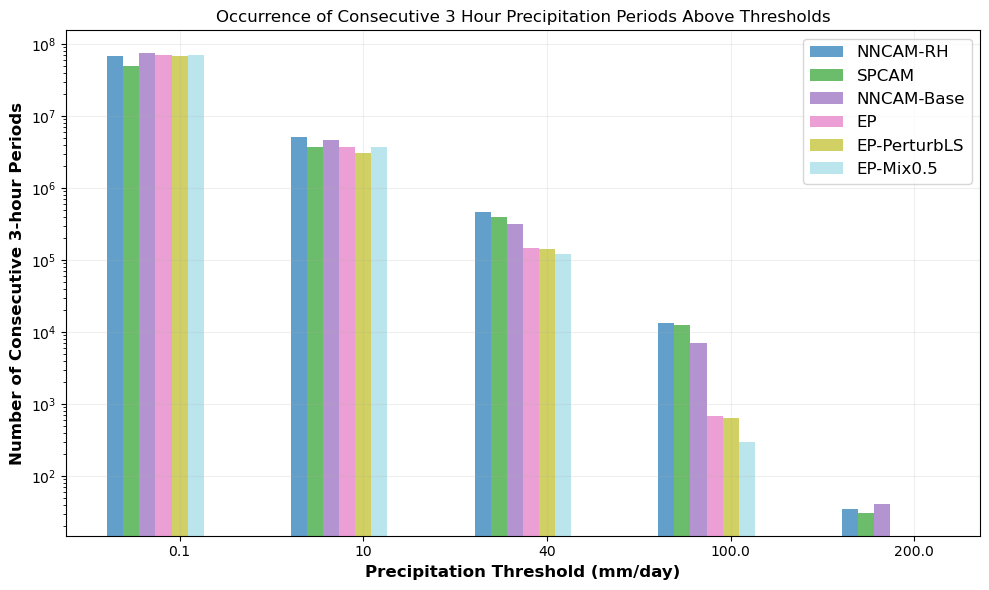

In [125]:
# Plot the occurrence of consecutive precipitation periods for each threshold
plt.figure(figsize=(10, 6))  # Explicitly set DPI to control output size

x = np.arange(len(thresholds))
width = 0.35

# Create dictionary of model data and colors
model_data = {
    'NNCAM-RH': nncam_consecutives,
    'EP': ep_consecutives,
    'NNCAM-Base': nncam_base_consecutives,
    'EP-PerturbLS': ep_perturb_consecutives, 
    'EP-Mix0.5': epmix_consecutives,
    # 'NoEP-MinMax': noep_minmax_consecutives,
    # 'NoEP-Std': noep_std_consecutives,
    'SPCAM': spcam_consecutives
}

# Sort models by second last value
sorted_models = sorted(model_data.items(), 
                      key=lambda x: x[1][-2],
                      reverse=True)

colors = plt.cm.tab20(np.linspace(0, 1, len(model_data)))

# Plot bars for each model
for i, (model, values) in enumerate(sorted_models):
    plt.bar(x + i*width/4 - width, values,
            width=width/4,
            label=model,
            alpha=0.7,
            color=colors[i])

plt.xlabel('Precipitation Threshold (mm/day)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel('Number of Consecutive 3-hour Periods', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.title('Occurrence of Consecutive 3 Hour Precipitation Periods Above Thresholds')
plt.xticks(x, thresholds, fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(fontsize=PLOT_CONFIG['tick_fontsize'])
plt.legend(fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, alpha=0.2)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to prevent text cutoff
plt.show()


Setting plot limits and ticks


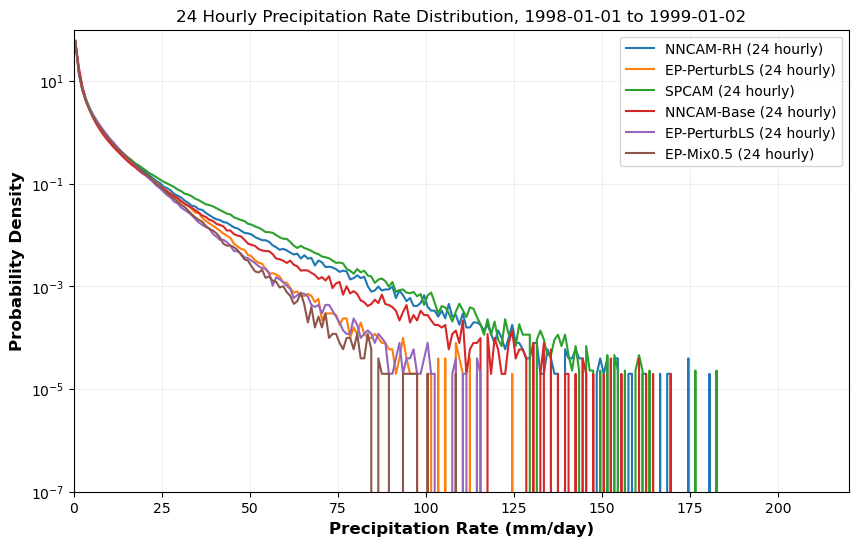

In [127]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1999-01-02'].resample('24h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1999-01-02'].resample('24h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1999-01-02'].resample('24h').mean()
# noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
# noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1999-01-02'].resample('24h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1999-01-02'].resample('24h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1999-01-02'].resample('24h').mean()


# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
# hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
# hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam_base, bins_nncam_base = np.histogram(nncam_base_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep_perturb, bins_ep_perturb = np.histogram(ep_perturb_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_epmix, bins_epmix = np.histogram(epmix_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
# bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
# bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
bin_centers_nncam_base = (bins_nncam_base[:-1] + bins_nncam_base[1:]) / 2
bin_centers_ep_perturb = (bins_ep_perturb[:-1] + bins_ep_perturb[1:]) / 2
bin_centers_epmix = (bins_epmix[:-1] + bins_epmix[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (24 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (24 hourly)')
# plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (24 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)')
# plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (24 hourly)')
plt.semilogy(bin_centers_nncam_base, hist_nncam_base*100, label='NNCAM-Base (24 hourly)')
plt.semilogy(bin_centers_ep_perturb, hist_ep_perturb*100, label='EP-PerturbLS (24 hourly)')
plt.semilogy(bin_centers_epmix, hist_epmix*100, label='EP-Mix0.5 (24 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('24 Hourly Precipitation Rate Distribution, 1998-01-01 to 1999-01-02')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

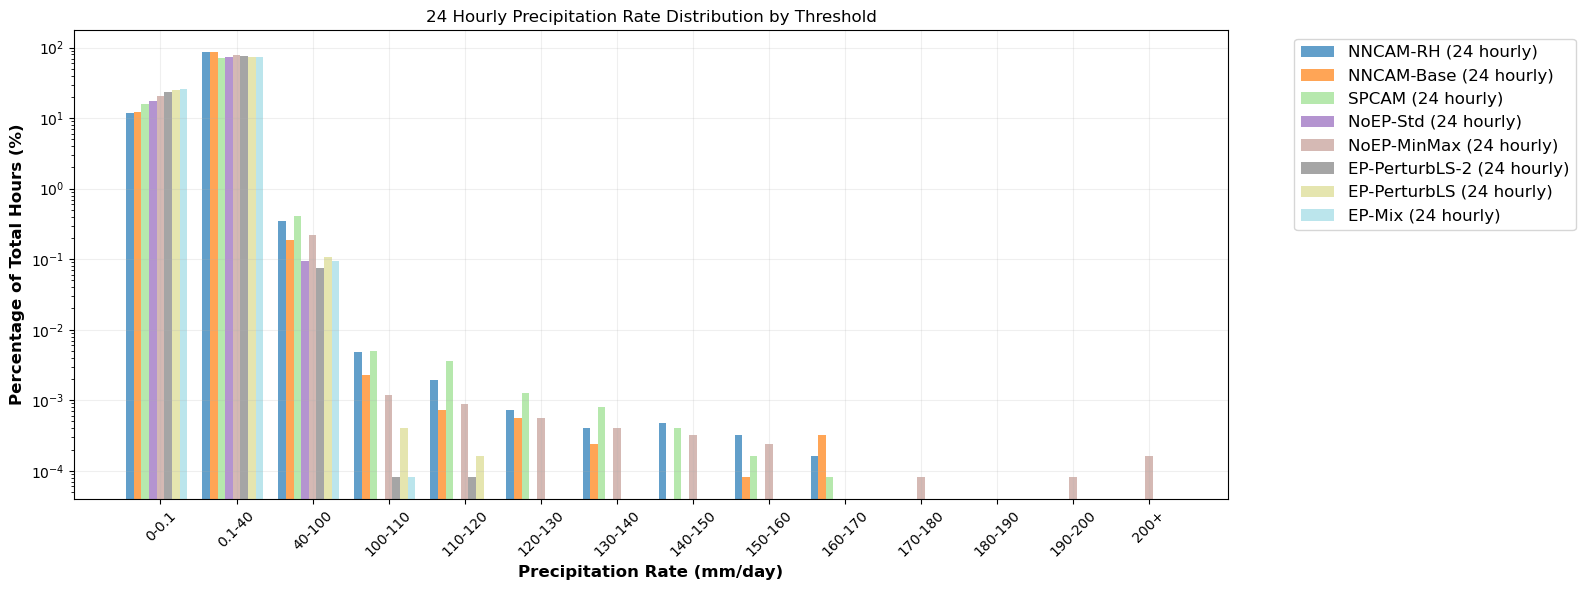

In [97]:
# Resample to 24 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
nncam_base_hourly = nncam_base_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
epmix_hourly = epmix_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()
ep_perturb_hourly = ep_perturbls_df.loc['1998-01-01':'1998-03-31'].resample('24h').mean()

# Convert back to flattened arrays
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
nncam_base_flat_hourly = nncam_base_hourly.values.flatten()
epmix_flat_hourly = epmix_hourly.values.flatten()
ep_perturb_flat_hourly = ep_perturb_hourly.values.flatten()

# Define threshold bins and labels
bins = [0, 0.1, 40, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, np.inf]
bin_labels = ['0-0.1', '0.1-40', '40-100', '100-110', '110-120', '120-130', '130-140', '140-150',
              '150-160', '160-170', '170-180', '180-190', '190-200', '200+']

# Create dictionary of model data
model_data = {
    'NNCAM-RH': nncam_flat_hourly,
    'EP-PerturbLS': ep_flat_hourly, 
    'NoEP-MinMax': noep_minmax_flat_hourly,
    'SPCAM': spcam_flat_hourly,
    'NoEP-Std': noep_std_flat_hourly,
    'NNCAM-Base': nncam_base_flat_hourly,
    'EP-Mix': epmix_flat_hourly,
    'EP-PerturbLS-2': ep_perturb_flat_hourly
}

# Calculate histograms and percentages
hist_data = {}
for model, data in model_data.items():
    hist, _ = np.histogram(data, bins=bins)
    hist_data[model] = (hist / len(data)) * 100

# Create DataFrame and sort by first bin values
df = pd.DataFrame(hist_data).T
df.columns = bin_labels
df = df.sort_values(by='0-0.1', ascending=True)

# Set up plot
fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(bin_labels))
bar_width = 0.1
colors = plt.cm.tab20(np.linspace(0, 1, len(model_data)))

# Plot bars for each model
for i, (model, values) in enumerate(df.iterrows()):
    ax.bar(x + i*bar_width, values, 
           width=bar_width, 
           label=f'{model} (24 hourly)',
           alpha=0.7,
           color=colors[i])

# Customize plot
plt.xlabel('Precipitation Rate (mm/day)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel('Percentage of Total Hours (%)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.title('24 Hourly Precipitation Rate Distribution by Threshold')
plt.xticks(x + bar_width*len(model_data)/2, bin_labels, fontsize=PLOT_CONFIG['tick_fontsize'], rotation=45)
plt.yticks(fontsize=PLOT_CONFIG['tick_fontsize'])
plt.legend(fontsize=PLOT_CONFIG['legend_fontsize'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.yscale('log')

plt.tight_layout()
plt.show()

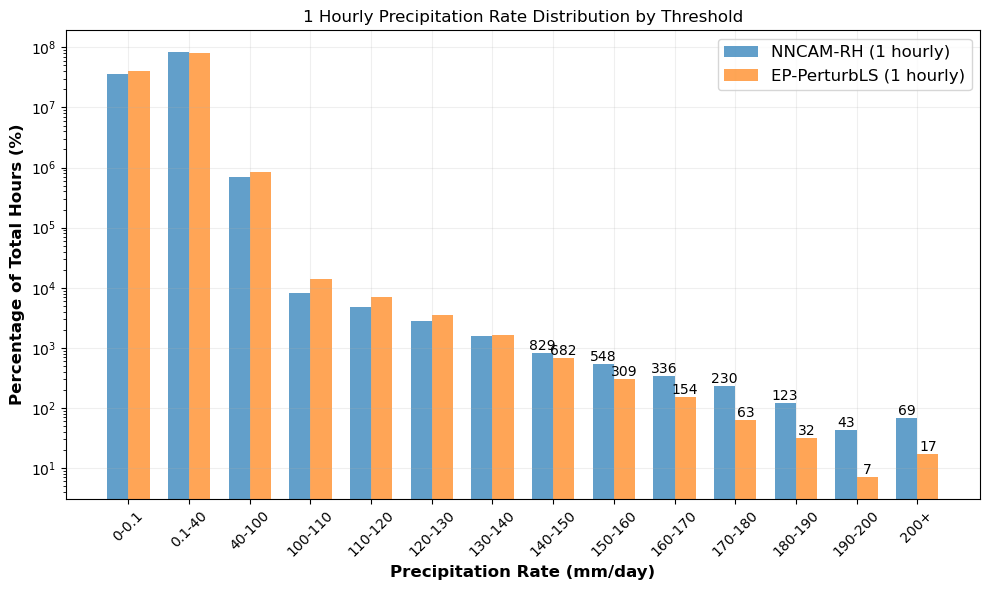

In [44]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.resample('h').mean()
ep_hourly = ep_df.resample('h').mean()

# Convert back to flattened arrays
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()

# Define threshold bins
bins = [0, 0.1, 40, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, np.inf]
bin_labels = ['0-0.1', '0.1-40', '40-100', '100-110', '110-120', '120-130', '130-140', '140-150', 
              '150-160', '160-170', '170-180', '180-190', '190-200', '200+']

# Calculate histograms
nncam_hist, _ = np.histogram(nncam_flat_hourly, bins=bins)
ep_hist, _ = np.histogram(ep_flat_hourly, bins=bins)

# Convert to percentages
nncam_pct = (nncam_hist / len(nncam_flat_hourly)) * 100
ep_pct = (ep_hist / len(ep_flat_hourly)) * 100

# Create bar plot
plt.figure(figsize=(10, 6))
x = np.arange(len(bin_labels))
width = 0.35

plt.bar(x - width/2, nncam_hist, width, label='NNCAM-RH (1 hourly)', alpha=0.7)
plt.bar(x + width/2, ep_hist, width, label='EP-PerturbLS (1 hourly)', alpha=0.7)

# Add value labels
for i in range(-7, 0, 1):
    plt.text(x[i] - width/2, nncam_hist[i], f'{nncam_hist[i]}', 
             ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, ep_hist[i], f'{ep_hist[i]}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Precipitation Rate (mm/day)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel('Percentage of Total Hours (%)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.title('1 Hourly Precipitation Rate Distribution by Threshold')
plt.xticks(x, bin_labels, fontsize=PLOT_CONFIG['tick_fontsize'], rotation=45)
plt.yticks(fontsize=PLOT_CONFIG['tick_fontsize'])
plt.legend(fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, alpha=0.2)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [139]:
# Define threshold for precipitation (mm/day)
thresholds = [0.1, 10, 40,  100.0, 200.0]  # Can be adjusted as needed

# Initialize arrays to store consecutive precipitation counts
nncam_consecutive = np.zeros_like(nncam_df[0,0,:])  # Shape (13824,)
ep_consecutive = np.zeros_like(ep_df[0,0,:])  # Shape (13824,)
ep_perturb_consecutive = np.zeros_like(ep_perturb_df[0,0,:])  # Shape (13824,)


# Create rolling windows of 3 hours for each day and grid point
nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
# nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)
print(nncam_windows.shape)
# ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)


nncam_consecutives = []
ep_consecutives = []

# # Check where all values in each window exceed threshold
for threshold in thresholds:
    print(f"\nFor threshold {threshold} mm/day:")
    nncam_consecutive_periods = np.all(nncam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    ep_consecutive_periods = np.all(ep_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    
    # Sum across days and hours to get total count for each grid point
    nncam_consecutive = np.sum(nncam_consecutive_periods)  # Shape (13824,)
    ep_consecutive = np.sum(ep_consecutive_periods)  # Shape (13824,)
    nncam_consecutives.append(nncam_consecutive)
    ep_consecutives.append(ep_consecutive)
    
    print(f"NNCAM-RH consecutive periods: {nncam_consecutive}")
    print(f"EP-PerturbLS consecutive periods: {ep_consecutive}")

(365, 22, 13824, 3)

For threshold 0.1 mm/day:
NNCAM-RH consecutive periods: 68464402
EP-PerturbLS consecutive periods: 67368471

For threshold 10 mm/day:
NNCAM-RH consecutive periods: 5052474
EP-PerturbLS consecutive periods: 3048890

For threshold 40 mm/day:
NNCAM-RH consecutive periods: 457648
EP-PerturbLS consecutive periods: 140999

For threshold 100.0 mm/day:
NNCAM-RH consecutive periods: 13518
EP-PerturbLS consecutive periods: 650

For threshold 200.0 mm/day:
NNCAM-RH consecutive periods: 35
EP-PerturbLS consecutive periods: 0


3048890
140999
650
0


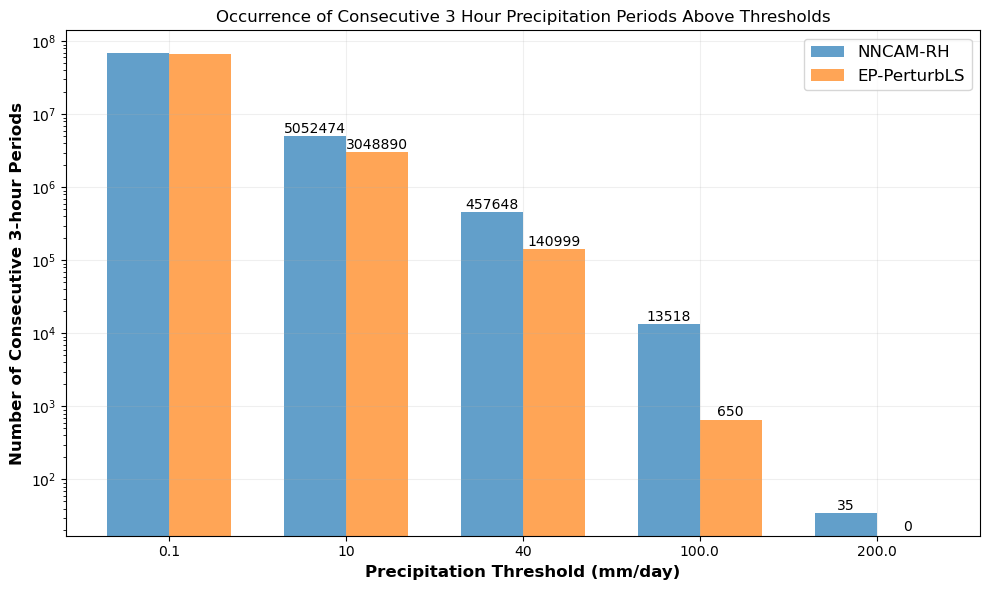

In [175]:
# Plot the occurrence of consecutive precipitation periods for each threshold
plt.figure(figsize=(10, 6))  # Explicitly set DPI to control output size

x = np.arange(len(thresholds))
width = 0.35
# Create the bars
nncam_bars = plt.bar(x - width/2, nncam_consecutives, width, label='NNCAM-RH', color='tab:blue', alpha=0.7)
ep_bars = plt.bar(x + width/2, ep_consecutives, width, label='EP-PerturbLS', color='tab:orange', alpha=0.7)

# Add value labels for last two thresholds
for i in [-4, -3, -2, -1]:  # Index for last two thresholds
    plt.text(x[i] - width/2, nncam_consecutives[i], f'{int(nncam_consecutives[i])}', 
             ha='center', va='bottom', fontsize=10)
    print(ep_consecutives[i])
    plt.text(x[i] + width/2, ep_consecutives[i]+18, f'{int(ep_consecutives[i])}', 
             ha='center', va='bottom', fontsize=10)
    # plt.text(x[i] - width/2, ep_consecutives[i], f'{int(ep_consecutives[i])}',
    #          ha='center', va='bottom', fontsize=10)

plt.xlabel('Precipitation Threshold (mm/day)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel('Number of Consecutive 3-hour Periods', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.title('Occurrence of Consecutive 3 Hour Precipitation Periods Above Thresholds')
plt.xticks(x, thresholds, fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(fontsize=PLOT_CONFIG['tick_fontsize'])
plt.legend(fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, alpha=0.2)
plt.yscale('log')

# Set figure size limits to prevent oversized output
# plt.gcf().set_size_inches(10, 6)
plt.tight_layout()  # Adjust layout to prevent text cutoff
plt.show()


In [40]:
noep_precip_online = pd.read_csv("/Users/jianda/Projects/experience_replay_data/noep_precip/noep_precip.csv")

In [41]:
noep_precip_online['Unnamed: 0'] = pd.to_datetime(noep_precip_online['Unnamed: 0'])
noep_precip_online.set_index('Unnamed: 0', inplace=True)

In [33]:
#spcam_precip = pd.read_csv("/Users/jianda/Projects/experience_replay_data/noep_precip/precip_gt_NoEP1117_precip_analysi.csv")
spcam_precip = pd.read_csv("/Users/jianda/Projects/experience_replay_data/spcam_data/spcam_precip.csv")
noep_precip_offline = pd.read_csv("/Users/jianda/Projects/experience_replay_data/noep_precip/precip_pred_NoEP1117_precip_analysi.csv")
noep_precip_minmax_offline = pd.read_csv("/Users/jianda/Projects/experience_replay_data/noep_minmax_data/precip_pred_NoEP1117_minmax_precip_analysi.csv")

In [34]:
spcam_precip['Unnamed: 0'] = pd.to_datetime(spcam_precip['Unnamed: 0'])
spcam_precip.set_index('Unnamed: 0', inplace=True)
noep_precip_offline['Unnamed: 0'] = pd.to_datetime(noep_precip_offline['Unnamed: 0'])
noep_precip_offline.set_index('Unnamed: 0', inplace=True)
noep_precip_minmax_offline['Unnamed: 0'] = pd.to_datetime(noep_precip_minmax_offline['Unnamed: 0'])
noep_precip_minmax_offline.set_index('Unnamed: 0', inplace=True)


Setting plot limits and ticks


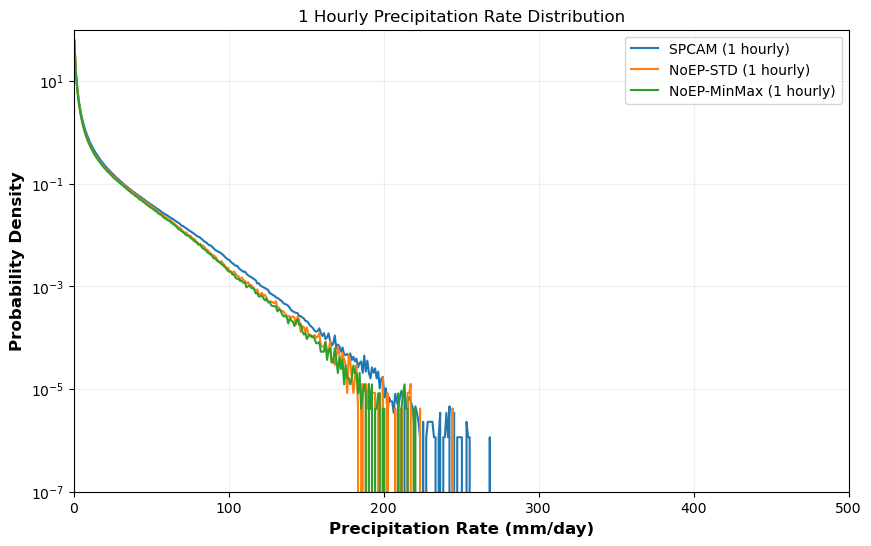

In [35]:
# Resample to 6 hourly averages using pandas
spcam_hourly = spcam_precip.resample('h').mean()
noep_hourly = noep_precip_offline.resample('h').mean()
noep_minmax_hourly = noep_precip_minmax_offline.resample('h').mean()

# Convert back to flattened arrays and filter small values
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_flat_hourly = noep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()

# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep, bins_noep = np.histogram(noep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_noep = (bins_noep[:-1] + bins_noep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (1 hourly)')
plt.semilogy(bin_centers_noep, hist_noep*100, label='NoEP-STD (1 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (1 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('1 Hourly Precipitation Rate Distribution')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


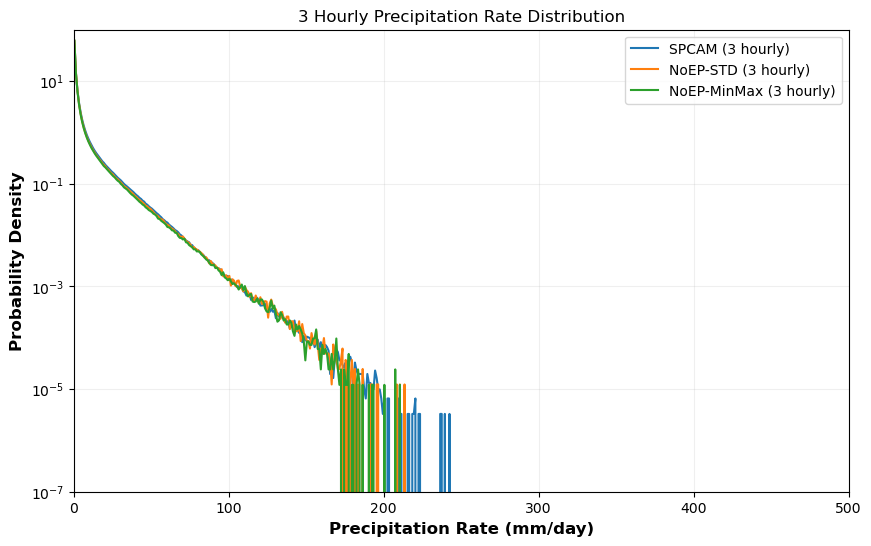

In [36]:
# Resample to 6 hourly averages using pandas
spcam_hourly = spcam_precip.resample('3h').mean()
noep_hourly = noep_precip_offline.resample('3h').mean()
noep_minmax_hourly = noep_precip_minmax_offline.resample('3h').mean()

# Convert back to flattened arrays and filter small values
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_flat_hourly = noep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()

# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep, bins_noep = np.histogram(noep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
# hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_noep = (bins_noep[:-1] + bins_noep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (3 hourly)')
plt.semilogy(bin_centers_noep, hist_noep*100, label='NoEP-STD (3 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (3 hourly)')
# plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (1 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('3 Hourly Precipitation Rate Distribution')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


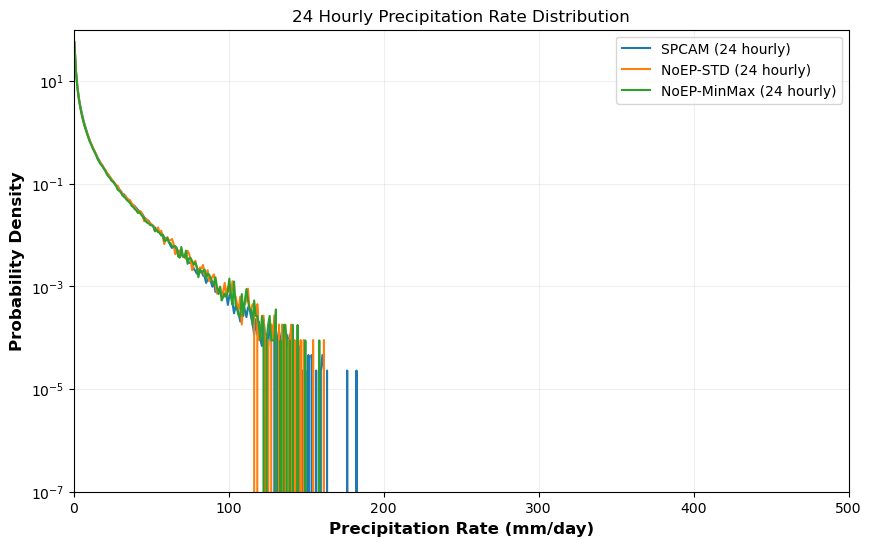

In [37]:
# Resample to 6 hourly averages using pandas
spcam_hourly = spcam_precip.resample('24h').mean()
noep_hourly = noep_precip_offline.resample('24h').mean()
noep_minmax_hourly = noep_precip_minmax_offline.resample('24h').mean()

# Convert back to flattened arrays and filter small values
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_flat_hourly = noep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()

# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep, bins_noep = np.histogram(noep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
# hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_noep = (bins_noep[:-1] + bins_noep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)')
plt.semilogy(bin_centers_noep, hist_noep*100, label='NoEP-STD (24 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (24 hourly)')
# plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (1 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('24 Hourly Precipitation Rate Distribution')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
noep_minmax_dir = "/Users/jianda/Projects/experience_replay_data/noep_minmax_data/nc_files/"
dfs = []
for file in os.listdir(noep_minmax_dir):
    if "h1" in file and file.endswith(".nc"):
        print(file)
        noep_minmax_data = nc.Dataset(noep_minmax_dir + file)["cp"]
        noep_minmax_data = noep_minmax_data[:] * 24 * 60 * 60 * 1000
        print(noep_minmax_data.mean())
        time = nc.Dataset(noep_minmax_dir + file)["time"]
        # Convert time to datetime
        time_values = nc.num2date(time[:], time.units)
        # Reshape precipitation arrays to 2D (time, lat*lon)
        noep_minmax_data_flat = noep_minmax_data.reshape(noep_minmax_data.shape[0], -1)

        # Convert cftime DatetimeGregorian to pandas datetime
        time_values_pd = pd.to_datetime([str(t) for t in time_values])
        # Create DataFrames with time index
        noep_minmax_df = pd.DataFrame(noep_minmax_data_flat, index=time_values_pd)
        dfs.append(noep_minmax_df)
noep_minmax_df = pd.concat(dfs)
noep_minmax_df = noep_minmax_df.sort_index()
noep_minmax_df.to_csv("/Users/jianda/Projects/experience_replay_data/noep_minmax_data/noep_minmax_precip.csv")

conv_mem_share3.cam.h1.1999-04-26-00000.nc
2.1080682
conv_mem_share3.cam.h1.1998-11-27-00000.nc
2.032234
conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.081493
conv_mem_share3.cam.h1.1999-01-26-00000.nc
1.9983617
conv_mem_share3.cam.h1.1998-10-28-00000.nc
2.0130916
conv_mem_share3.cam.h1.1998-12-27-00000.nc
1.99799
conv_mem_share3.cam.h1.1998-09-28-00000.nc
2.0526865
conv_mem_share3.cam.h1.1998-07-30-00000.nc
2.1623087
conv_mem_share3.cam.h1.1998-05-01-00000.nc
2.1521006
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.0787337
conv_mem_share3.cam.h1.1998-05-31-00000.nc
2.1800334
conv_mem_share3.cam.h1.1999-05-26-00000.nc
2.147828
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.072044
conv_mem_share3.cam.h1.1998-08-29-00000.nc
2.1153886
conv_mem_share3.cam.h1.1998-06-30-00000.nc
2.2258806
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.1498857
conv_mem_share3.cam.h1.1999-03-27-00000.nc
2.0473115
conv_mem_share3.cam.h1.1999-02-25-00000.nc
2.0300324


In [65]:
nncam_base_dir = "/Users/jianda/Projects/experience_replay_data/nncam_data/nc_files/"
dfs = []
for file in os.listdir(nncam_base_dir):
    if "h1" in file and file.endswith(".nc"):
        print(file)
        nncam_base_data = nc.Dataset(nncam_base_dir + file)["cp"]
        nncam_base_data = nncam_base_data[:] * 24 * 60 * 60 * 1000
        print(nncam_base_data.mean())
        time = nc.Dataset(nncam_base_dir + file)["time"]
        # Convert time to datetime
        time_values = nc.num2date(time[:], time.units)
        # Reshape precipitation arrays to 2D (time, lat*lon)
        nncam_base_data_flat = nncam_base_data.reshape(nncam_base_data.shape[0], -1)

        # Convert cftime DatetimeGregorian to pandas datetime
        time_values_pd = pd.to_datetime([str(t) for t in time_values])
        # Create DataFrames with time index
        nncam_base_df = pd.DataFrame(nncam_base_data_flat, index=time_values_pd)
        dfs.append(nncam_base_df)
nncam_base_df = pd.concat(dfs)
nncam_base_df = nncam_base_df.sort_index()
nncam_base_df.to_csv("/Users/jianda/Projects/experience_replay_data/nncam_data/nncam_precip.csv")

conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.15566
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.2481048
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.2330842
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.2711115


Setting plot limits and ticks


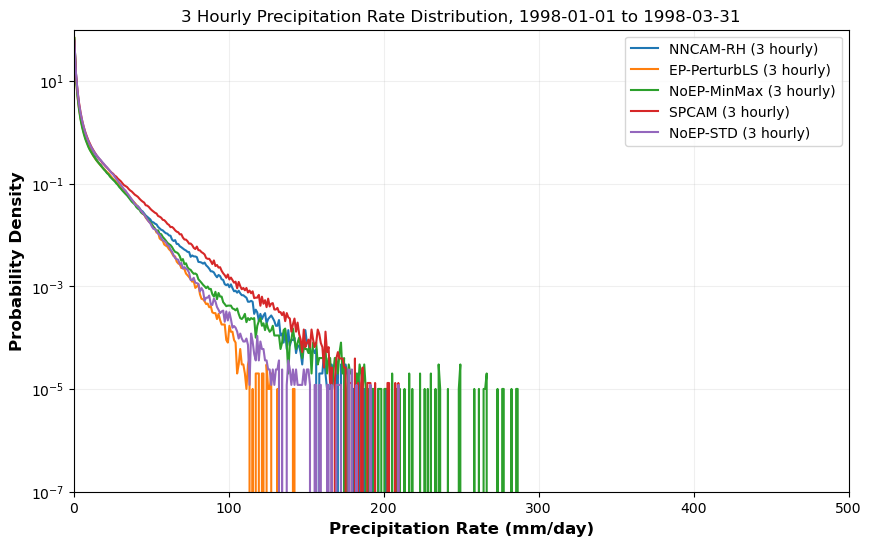

In [51]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('3h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('3h').mean()

# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (3 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (3 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (3 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (3 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (3 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('3 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


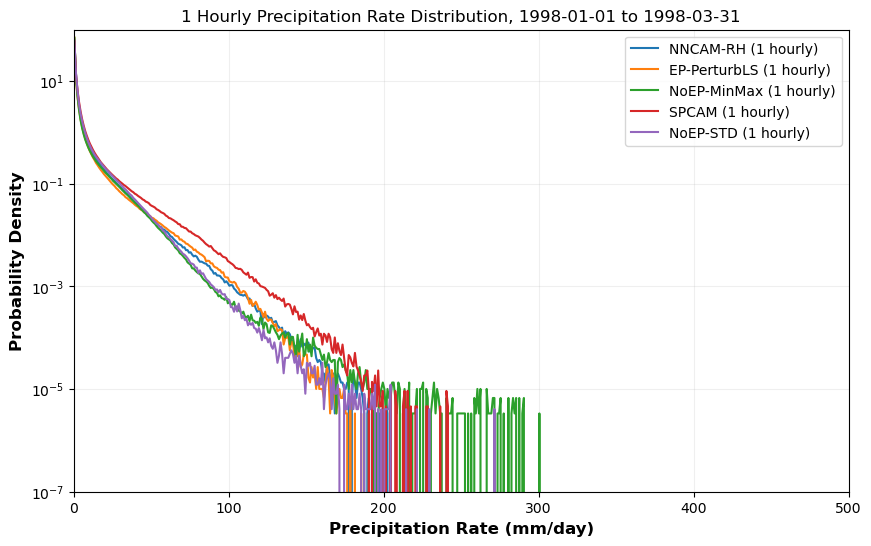

In [52]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
noep_std_hourly = noep_precip_online.loc['1998-01-01':'1998-03-31'].resample('1h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-03-31'].resample('1h').mean()

# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
noep_std_flat_hourly = noep_std_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_std, bins_noep_std = np.histogram(noep_std_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_noep_std = (bins_noep_std[:-1] + bins_noep_std[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (1 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (1 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (1 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (1 hourly)')
plt.semilogy(bin_centers_noep_std, hist_noep_std*100, label='NoEP-STD (1 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('1 Hourly Precipitation Rate Distribution, 1998-01-01 to 1998-03-31')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


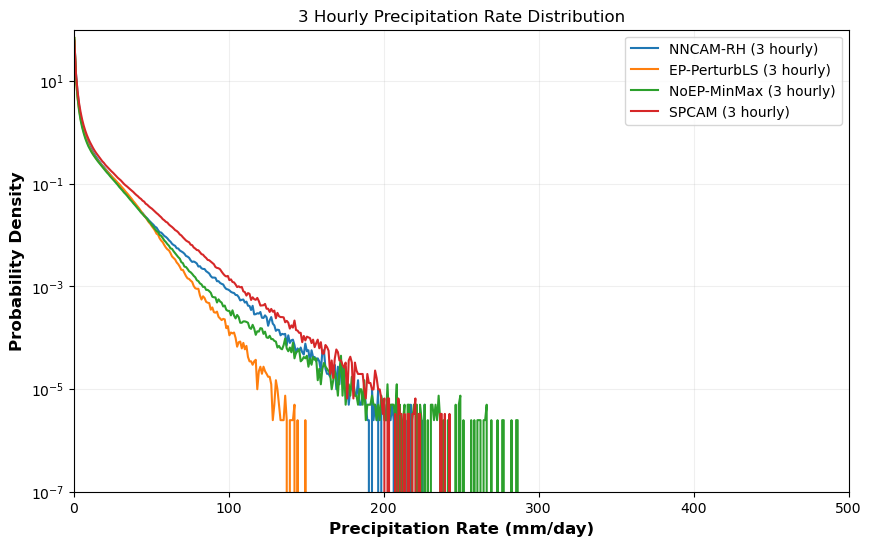

In [38]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-12-31'].resample('3h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-12-31'].resample('3h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-12-31'].resample('3h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-12-31'].resample('3h').mean()

# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (3 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (3 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (3 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (3 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('3 Hourly Precipitation Rate Distribution')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

Setting plot limits and ticks


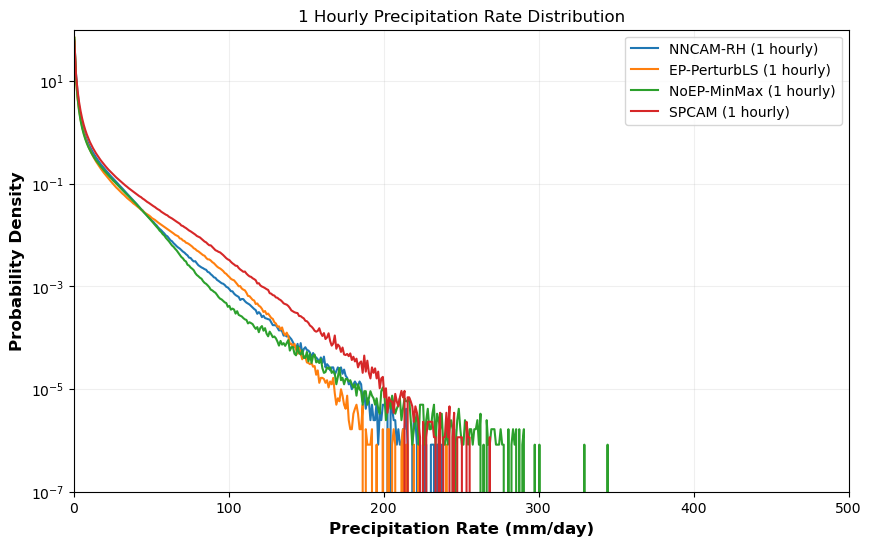

In [49]:
# Resample to 6 hourly averages using pandas
nncam_hourly = nncam_df.loc['1998-01-01':'1998-12-31'].resample('1h').mean()
ep_hourly = ep_df.loc['1998-01-01':'1998-12-31'].resample('1h').mean()
noep_minmax_hourly = noep_minmax_df.loc['1998-01-01':'1998-12-31'].resample('1h').mean()
spcam_hourly = spcam_precip.loc['1998-01-01':'1998-12-31'].resample('1h').mean()

# Convert back to flattened arrays and filter small values
nncam_flat_hourly = nncam_hourly.values.flatten()
ep_flat_hourly = ep_hourly.values.flatten()
noep_minmax_flat_hourly = noep_minmax_hourly.values.flatten()
spcam_flat_hourly = spcam_hourly.values.flatten()
# nncam_flat_hourly = nncam_flat_hourly[nncam_flat_hourly > 0.1]
# ep_flat_hourly = ep_flat_hourly[ep_flat_hourly > 0.1]

# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_nncam, bins_nncam = np.histogram(nncam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_ep, bins_ep = np.histogram(ep_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_noep_minmax, bins_noep_minmax = np.histogram(noep_minmax_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_spcam, bins_spcam = np.histogram(spcam_flat_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
# print(bin_centers_nncam)
bin_centers_ep = (bins_ep[:-1] + bins_ep[1:]) / 2
# print(bin_centers_ep)
bin_centers_noep_minmax = (bins_noep_minmax[:-1] + bins_noep_minmax[1:]) / 2
bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM-RH (1 hourly)')
plt.semilogy(bin_centers_ep, hist_ep*100, label='EP-PerturbLS (1 hourly)')
plt.semilogy(bin_centers_noep_minmax, hist_noep_minmax*100, label='NoEP-MinMax (1 hourly)')
plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (1 hourly)')
        # hist, bin_edges = np.histogram(daily_cp_data, bins=np.linspace(0, 200, 201), density=True)
        # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        # results['DailyNoExperienceReplay'] = (bin_centers, hist * 100)  # Multiply by 100 to convert to percentage
plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
# plt.title(f"{PLOT_CONFIG['main']['title']} ({'Histogram' , fontweight='bold', fontsize=PLOT_CONFIG['common']['title_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title('1 Hourly Precipitation Rate Distribution')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [46]:
# Define threshold for precipitation (mm/day)
thresholds = [0.1, 10, 40,  100.0, 200.0]  # Can be adjusted as needed
nncam_half_hourly = nncam_df.loc['1998-01-02':'1998-03-31'].copy()
nncam_daily = nncam_half_hourly.values.reshape(-1, 24, 13824)
ep_half_hourly = ep_df.loc['1998-01-02':'1998-03-31'].copy()
ep_daily = ep_half_hourly.values.reshape(-1, 24, 13824)
noep_minmax_half_hourly = noep_minmax_df.loc['1998-01-02':'1998-03-31'].copy()
noep_minmax_daily = noep_minmax_half_hourly.values.reshape(-1, 24, 13824)
noep_std_half_hourly = noep_precip_online.loc['1998-01-02':'1998-03-31'].copy()
noep_std_daily = noep_std_half_hourly.values.reshape(-1, 24, 13824)
spcam_half_hourly = spcam_precip.loc['1998-01-02':'1998-03-31'].copy()
spcam_daily = spcam_half_hourly.values.reshape(-1, 24, 13824)

# Initialize arrays to store consecutive precipitation counts
nncam_consecutive = np.zeros_like(nncam_daily[0,0,:])  # Shape (13824,)
ep_consecutive = np.zeros_like(ep_daily[0,0,:])  # Shape (13824,)
noep_minmax_consecutive = np.zeros_like(noep_minmax_daily[0,0,:])  # Shape (13824,)
noep_std_consecutive = np.zeros_like(noep_std_daily[0,0,:])  # Shape (13824,)
spcam_consecutive = np.zeros_like(spcam_daily[0,0,:])  # Shape (13824,)

# Create rolling windows of 3 hours for each day and grid point
nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
noep_minmax_windows = np.lib.stride_tricks.sliding_window_view(noep_minmax_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
noep_std_windows = np.lib.stride_tricks.sliding_window_view(noep_std_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
spcam_windows = np.lib.stride_tricks.sliding_window_view(spcam_daily, window_shape=(1,3,1))[:,:,:,0,:,0]  # Shape (365, 22, 13824)
# nncam_windows = np.lib.stride_tricks.sliding_window_view(nncam_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)
print(nncam_windows.shape)
# ep_windows = np.lib.stride_tricks.sliding_window_view(ep_daily, window_shape=(1,3,1))  # Shape (365, 22, 13824)


nncam_consecutives = []
ep_consecutives = []
noep_minmax_consecutives = []
noep_std_consecutives = []
spcam_consecutives = []

# # Check where all values in each window exceed threshold
for threshold in thresholds:
    print(f"\nFor threshold {threshold} mm/day:")
    nncam_consecutive_periods = np.all(nncam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    ep_consecutive_periods = np.all(ep_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    noep_minmax_consecutive_periods = np.all(noep_minmax_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    noep_std_consecutive_periods = np.all(noep_std_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    spcam_consecutive_periods = np.all(spcam_windows > threshold, axis=3)  # Shape (365, 22, 13824)
    # Sum across days and hours to get total count for each grid point
    nncam_consecutive = np.sum(nncam_consecutive_periods)  # Shape (13824,)
    ep_consecutive = np.sum(ep_consecutive_periods)  # Shape (13824,)
    noep_minmax_consecutive = np.sum(noep_minmax_consecutive_periods)  # Shape (13824,)
    noep_std_consecutive = np.sum(noep_std_consecutive_periods)  # Shape (13824,)
    spcam_consecutive = np.sum(spcam_consecutive_periods)  # Shape (13824,)
    nncam_consecutives.append(nncam_consecutive)
    ep_consecutives.append(ep_consecutive)
    noep_minmax_consecutives.append(noep_minmax_consecutive)
    noep_std_consecutives.append(noep_std_consecutive)
    spcam_consecutives.append(spcam_consecutive)
    
    print(f"NNCAM-RH consecutive periods: {nncam_consecutive}")
    print(f"EP-PerturbLS consecutive periods: {ep_consecutive}")
    print(f"NoEP-MinMax consecutive periods: {noep_minmax_consecutive}")
    print(f"NoEP-STD consecutive periods: {noep_std_consecutive}")
    print(f"SPCAM consecutive periods: {spcam_consecutive}")


(89, 22, 13824, 3)

For threshold 0.1 mm/day:
NNCAM-RH consecutive periods: 16362463
EP-PerturbLS consecutive periods: 16198026
NoEP-MinMax consecutive periods: 17396972
NoEP-STD consecutive periods: 33725592
SPCAM consecutive periods: 23753737

For threshold 10 mm/day:
NNCAM-RH consecutive periods: 1207184
EP-PerturbLS consecutive periods: 723093
NoEP-MinMax consecutive periods: 1065427
NoEP-STD consecutive periods: 2199193
SPCAM consecutive periods: 2008999

For threshold 40 mm/day:
NNCAM-RH consecutive periods: 128731
EP-PerturbLS consecutive periods: 38796
NoEP-MinMax consecutive periods: 92247
NoEP-STD consecutive periods: 142720
SPCAM consecutive periods: 246529

For threshold 100.0 mm/day:
NNCAM-RH consecutive periods: 3922
EP-PerturbLS consecutive periods: 100
NoEP-MinMax consecutive periods: 2228
NoEP-STD consecutive periods: 1132
SPCAM consecutive periods: 8678

For threshold 200.0 mm/day:
NNCAM-RH consecutive periods: 1
EP-PerturbLS consecutive periods: 0
NoEP-MinMax consecu

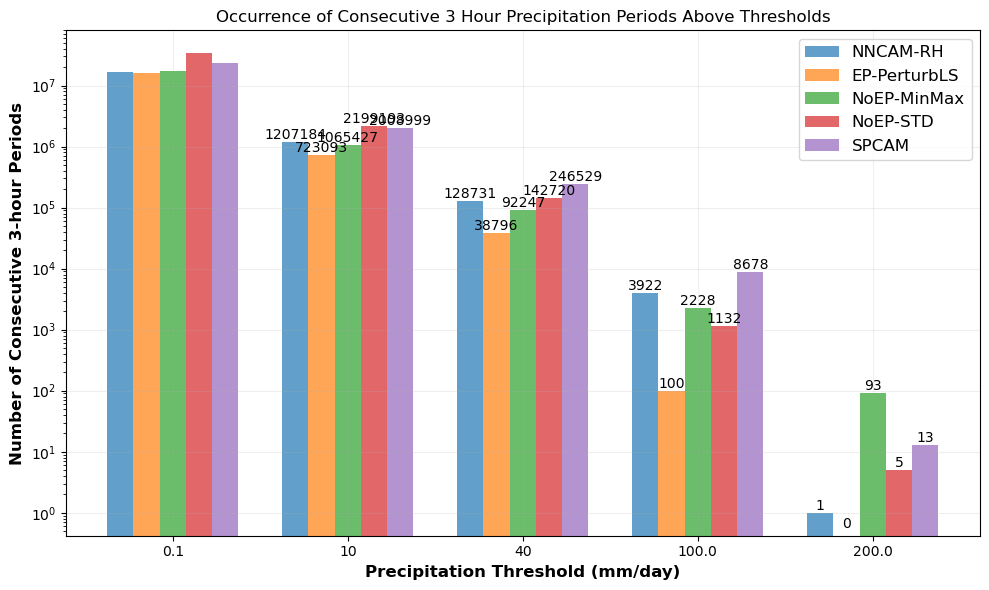

In [63]:
# Plot the occurrence of consecutive precipitation periods for each threshold
plt.figure(figsize=(10, 6))  # Explicitly set DPI to control output size

x = np.arange(len(thresholds))
width = 0.15  # Reduced width to fit 5 bars side by side

# Create the bars with adjusted positions
nncam_bars = plt.bar(x - 2*width, nncam_consecutives, width, label='NNCAM-RH', color='tab:blue', alpha=0.7)
ep_bars = plt.bar(x - width, ep_consecutives, width, label='EP-PerturbLS', color='tab:orange', alpha=0.7)
noep_minmax_bars = plt.bar(x, noep_minmax_consecutives, width, label='NoEP-MinMax', color='tab:green', alpha=0.7)
noep_std_bars = plt.bar(x + width, noep_std_consecutives, width, label='NoEP-STD', color='tab:red', alpha=0.7)
spcam_bars = plt.bar(x + 2*width, spcam_consecutives, width, label='SPCAM', color='tab:purple', alpha=0.7)

# Add value labels for last four thresholds
for i in [-4, -3, -2, -1]:  # Index for last four thresholds
    plt.text(x[i] - 2*width, nncam_consecutives[i], f'{int(nncam_consecutives[i])}', 
             ha='center', va='bottom', fontsize=10)
    plt.text(x[i] - width, np.max([ep_consecutives[i], 0.5]), f'{int(ep_consecutives[i])}', 
             ha='center', va='bottom', fontsize=10)
    plt.text(x[i], noep_minmax_consecutives[i], f'{int(noep_minmax_consecutives[i])}',
             ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width, noep_std_consecutives[i], f'{int(noep_std_consecutives[i])}',
             ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + 2*width, spcam_consecutives[i], f'{int(spcam_consecutives[i])}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Precipitation Threshold (mm/day)', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel('Number of Consecutive 3-hour Periods', fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.title('Occurrence of Consecutive 3 Hour Precipitation Periods Above Thresholds')
plt.xticks(x, thresholds, fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(fontsize=PLOT_CONFIG['tick_fontsize'])
plt.legend(fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, alpha=0.2)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to prevent text cutoff
plt.show()
